In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the model using the `CutOutSemantic` technique.

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from semantic_segmentation_augmentations.holemakertechnique import HoleMakerRandom, HoleMakerBounded, HoleMakerAttention
from semantic_segmentation_augmentations.holesfilling import CutOutSemantic

from vision_models_evaluation.core import evaluate

from sklearn.model_selection import KFold

import pandas as pd

import matplotlib.pyplot as plt

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn(x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        if len(x) == 2:
            img, mask = x
        elif len(x) == 1:
            img = x[0]
            mask = np.zeros_like(img)

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask
    
def decodes(mask):
    shape = mask.shape
    _mask = np.empty([*shape, 3])
    grape_c = np.array([255, 255, 255])
    leaves_c = np.array([0, 255, 0])
    pole_c = np.array([255, 0, 0])
    wood_c = np.array([0, 0, 255])
    back_c = np.array([0, 0, 0])
    
    for j in range(shape[0]):
        for i in range(shape[1]):
            if mask[j, i] == 1:
                _mask[j, i] = grape_c
            elif mask[j, i] == 2:
                _mask[j, i] = leaves_c
            elif mask[j, i] == 3:
                _mask[j, i] = pole_c
            elif mask[j, i] == 4:
                _mask[j, i] = wood_c
            else:
                _mask[j, i] = back_c
    
    return _mask.astype(np.uint8)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [ ]:
esc = EarlyStoppingCallback(patience = 5, min_delta = 0.01)

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [ ]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": []
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

saving_hparams = {
    "save_best": True,
    "metric": "DiceMulti",
    "model_name": "CutOutSemantic"
}

In order to know how does this technique work, we can show an example:

This technique cuts a random selected region of the image and removes a specified class inside it. The other information inside the region is not removed. The occlusion class can be randomly selected each time using the '-1' class.

Another `HoleMakerTechnique` can be selected to select the region, such as `HoleMakerBounded` or `HoleMakerAttention`.

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


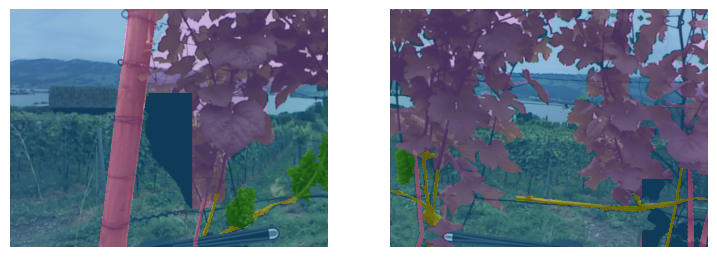

In [ ]:
cos = CutOutSemantic(holes_num = 1, occlusion_class = 2, hole_maker = HoleMakerRandom((250, 250)), p =1)
dls = DataBlock(**db_hparams).dataloaders(**dls_hparams)
with Learner(dls, resnet50(), metrics=[DiceMulti()], cbs = cos) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(1, 2, figsize=(9, 9))
dls.show_batch(b = (cos.x, cos.y), ctxs = axs.flatten())

Finally, we test the model with distinct hparams.

In [ ]:
results = {}

for holes_num in [1, 2]:
    for size in [(150, 150), (250, 250)]:
        for holemaker in [HoleMakerBounded, HoleMakerAttention]:
            cos = CutOutSemantic(holes_num = holes_num, hole_maker = holemaker(hole_size = size))
            learner_hparams["cbs"] = [esc, cos]
            r = evaluate(db_hparams,
                         dls_hparams,
                         technique,
                         learner_hparams,
                         learning_hparams,
                         learning_mode,
                         saving_hparams,
                         verbose = True
                        )
            results.update({
                str(holes_num) + str(size) + str(holemaker).split("'")[1].split(".")[2]: r["DiceMulti"]
            })

Starting the training for a new model
Training the fold 1


/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,dice_multi,time
0,0.855323,0.517377,0.348094,00:20
1,0.755323,0.777509,0.297383,00:19
2,0.887040,1.020119,0.197085,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.651770,0.472749,0.348656,00:19
1,0.525430,0.421070,0.429522,00:19
2,0.453938,0.375006,0.582067,00:19
3,0.407703,0.330541,0.599789,00:19
4,0.378571,0.330050,0.714171,00:19
5,0.344886,0.341717,0.736344,00:19
6,0.330277,0.363315,0.650975,00:19
7,0.319212,0.285292,0.800813,00:19
8,0.298398,0.288215,0.789152,00:19
9,0.306803,0.396689,0.772955,00:19


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.1954023540019989  /  DiceMulti: 0.847649268474522  
Saving best model because DiceMulti 0.8476 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.867088,0.542679,0.341361,00:19
1,0.655916,0.635577,0.290688,00:19
2,0.722822,0.516687,0.345647,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.448643,0.436988,0.404142,00:19
1,0.413877,0.375715,0.507881,00:20
2,0.385177,0.317906,0.551216,00:20
3,0.363575,0.309713,0.634957,00:20
4,0.340673,0.353620,0.685988,00:19
5,0.339786,0.414014,0.589781,00:19
6,0.331553,0.302075,0.757586,00:19
7,0.314018,0.362954,0.642089,00:19
8,0.311947,0.267416,0.771824,00:19
9,0.286851,0.248466,0.788408,00:19


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.22034141421318054  /  DiceMulti: 0.8228652170536271  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.801748,0.723259,0.324922,00:19
1,0.756833,0.753387,0.295603,00:19
2,0.926454,1.121539,0.165844,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.609589,0.439871,0.353200,00:20
1,0.510637,0.412299,0.352124,00:20
2,0.473095,0.373111,0.360527,00:20
3,0.424271,0.399516,0.474333,00:20
4,0.397897,0.351908,0.623546,00:20
5,0.360031,0.311225,0.720173,00:20
6,0.328823,0.308684,0.697262,00:20
7,0.314268,0.281514,0.785322,00:20
8,0.295436,0.279690,0.784110,00:20
9,0.294651,0.282447,0.789508,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.18288454413414001  /  DiceMulti: 0.8584826495838985  
Saving best model because DiceMulti 0.8585 >= 0.8476.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.865837,0.849895,0.220856,00:20
1,0.748009,0.575133,0.347484,00:19
2,0.655050,0.499437,0.345162,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.446826,0.318015,0.586586,00:20
1,0.396514,0.262391,0.749162,00:20
2,0.358150,0.237029,0.776456,00:20
3,0.336346,0.233387,0.790857,00:20
4,0.333066,0.317165,0.759909,00:20
5,0.316185,0.242328,0.812975,00:20
6,0.303195,0.234518,0.801761,00:20
7,0.300447,0.230263,0.783346,00:20


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.23082265257835388  /  DiceMulti: 0.8142535554089093  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.923819,0.928181,0.291743,00:20
1,0.704455,0.549632,0.349643,00:20
2,0.613923,0.451462,0.499410,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.392461,0.384064,0.551528,00:20
1,0.367000,0.313602,0.661740,00:20
2,0.337371,0.309095,0.720996,00:20
3,0.328225,0.343465,0.732101,00:20
4,0.343354,0.302316,0.730112,00:20
5,0.331469,0.298065,0.761897,00:20
6,0.315207,0.288788,0.807143,00:20
7,0.300598,0.255594,0.805416,00:20
8,0.291043,0.288493,0.786961,00:20
9,0.281687,0.279983,0.778194,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.2525084316730499  /  DiceMulti: 0.7867852338717223  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.048903,0.692451,0.305724,00:20
1,0.697807,0.511905,0.383250,00:20
2,0.567353,0.513567,0.406996,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.393851,0.464930,0.536683,00:20
1,0.346886,0.428608,0.641657,00:20
2,0.309360,0.396681,0.698387,00:20
3,0.288803,0.399727,0.705291,00:20
4,0.279347,0.423803,0.671005,00:20
5,0.274432,0.478459,0.652138,00:20
6,0.264133,0.482891,0.716771,00:20
7,0.276398,0.424782,0.692972,00:20


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.2849450707435608  /  DiceMulti: 0.7906961229329491  
Saving best model because DiceMulti 0.7907 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.923734,0.599486,0.330873,00:20
1,0.738706,0.477295,0.349124,00:20
2,0.598943,0.530903,0.342076,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.390618,0.325780,0.597030,00:20
1,0.354950,0.315394,0.644497,00:20
2,0.335498,0.276068,0.763378,00:20
3,0.315402,0.298560,0.741459,00:20
4,0.305233,0.267730,0.795388,00:20
5,0.314058,0.285017,0.758855,00:20
6,0.303784,0.290861,0.721699,00:20
7,0.289912,0.249114,0.791015,00:20
8,0.279057,0.263600,0.795212,00:20
9,0.272994,0.307130,0.819275,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.20986828207969666  /  DiceMulti: 0.8407424915432415  
Saving best model because DiceMulti 0.8407 >= 0.7907.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.013831,0.560759,0.344506,00:20
1,0.736313,0.485758,0.343398,00:20
2,0.600945,0.412380,0.490997,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.365268,0.339398,0.596638,00:21
1,0.353198,0.320950,0.714810,00:20
2,0.335809,0.311708,0.730895,00:20
3,0.314497,0.307675,0.733896,00:20
4,0.307207,0.299704,0.724236,00:20
5,0.296746,0.281777,0.765352,00:20
6,0.287767,0.302371,0.793149,00:20
7,0.286541,0.285743,0.774504,00:20
8,0.285651,0.290322,0.802615,00:20
9,0.274760,0.273833,0.803292,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.20023244619369507  /  DiceMulti: 0.8440930799483028  
Saving best model because DiceMulti 0.8441 >= 0.8407.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.933146,0.638920,0.334185,00:20
1,0.673400,0.472592,0.348279,00:20
2,0.649595,0.998034,0.196939,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.501863,0.315750,0.515955,00:20
1,0.447569,0.370643,0.594544,00:20
2,0.409918,0.318606,0.712691,00:20
3,0.380641,0.349892,0.724110,00:20
4,0.374883,0.270377,0.786433,00:20
5,0.355906,0.236372,0.789584,00:20
6,0.332480,0.315497,0.809843,00:20
7,0.317789,0.219372,0.816573,00:20
8,0.309936,0.225679,0.819564,00:20
9,0.304925,0.262817,0.765223,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.24904277920722961  /  DiceMulti: 0.831008213960542  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.954119,0.844633,0.287923,00:20
1,0.705793,0.495514,0.400835,00:20
2,0.611525,0.445803,0.353976,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.400175,0.358997,0.555440,00:20
1,0.368434,0.416429,0.535263,00:20
2,0.359920,0.324026,0.664798,00:20
3,0.340426,0.332124,0.757338,00:20
4,0.324438,0.298035,0.776449,00:20
5,0.324071,0.305630,0.695989,00:20
6,0.313406,0.389292,0.758982,00:20
7,0.300749,0.259714,0.799149,00:20
8,0.284381,0.280275,0.787615,00:20
9,0.282138,0.266615,0.787469,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.26377204060554504  /  DiceMulti: 0.7849115147011234  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.059434,0.925393,0.253241,00:20
1,0.791642,0.553382,0.326428,00:20
2,0.825832,0.879975,0.253317,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.524800,0.535258,0.328977,00:20
1,0.455325,0.481984,0.368848,00:20
2,0.410897,0.429274,0.565292,00:20
3,0.376646,0.506025,0.506505,00:20
4,0.351245,0.466668,0.659344,00:20
5,0.337332,0.414941,0.553367,00:20
6,0.322138,0.533848,0.675056,00:20
7,0.293331,0.470991,0.688555,00:20
8,0.279680,0.435994,0.699280,00:21
9,0.266491,0.378817,0.691060,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.1908920258283615  /  DiceMulti: 0.8353039123672203  
Saving best model because DiceMulti 0.8353 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.954046,0.694108,0.331249,00:20
1,0.711542,0.576863,0.331781,00:20
2,0.702182,0.560123,0.344769,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.462503,0.395547,0.448380,00:20
1,0.410116,0.362338,0.493583,00:20
2,0.391727,0.335214,0.569283,00:20
3,0.367712,0.414573,0.586241,00:20
4,0.359025,0.322598,0.740747,00:20
5,0.332277,0.270066,0.767966,00:20
6,0.332112,0.358000,0.743484,00:20
7,0.318286,0.276370,0.805444,00:20
8,0.299044,0.282478,0.800239,00:20
9,0.287614,0.254435,0.814188,00:20


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.19510532915592194  /  DiceMulti: 0.8562428031625385  
Saving best model because DiceMulti 0.8562 >= 0.8353.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.979427,0.666537,0.331507,00:20
1,0.640531,0.670971,0.336275,00:19
2,6.374373,85.562683,0.134324,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,17.347042,0.589461,0.319361,00:20
1,6.289312,0.423581,0.440137,00:20
2,3.014667,0.370374,0.513462,00:20
3,1.651249,0.366672,0.592266,00:20
4,1.004598,0.401815,0.515637,00:20
5,0.683720,0.321966,0.619889,00:20
6,0.554194,0.315403,0.652158,00:20
7,0.455125,0.332639,0.733068,00:20
8,0.383801,0.313015,0.749514,00:20
9,0.344084,0.387037,0.712090,00:20


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.2073100507259369  /  DiceMulti: 0.8532295660703557  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.877259,0.578978,0.338566,00:20
1,0.666775,0.531740,0.398077,00:20
2,0.708312,0.499445,0.341051,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.441980,0.346749,0.475195,00:20
1,0.398168,0.262396,0.722413,00:20
2,0.370570,0.271204,0.719437,00:20
3,0.348718,0.246106,0.760878,00:20
4,0.352290,0.336472,0.677536,00:20
5,0.352673,0.240046,0.776439,00:20
6,0.326710,0.247570,0.701531,00:20
7,0.312048,0.235114,0.811233,00:21
8,0.297910,0.221772,0.823446,00:20
9,0.286281,0.227850,0.788627,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.1970691978931427  /  DiceMulti: 0.8268476821626312  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.034105,0.798669,0.276751,00:19
1,0.709574,0.677045,0.325762,00:20
2,0.608604,0.887960,0.334598,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.415559,0.368349,0.553788,00:20
1,0.368717,0.306207,0.713837,00:20
2,0.341771,0.322827,0.599911,00:20
3,0.324816,0.308308,0.752157,00:20
4,0.326828,0.305694,0.762480,00:20
5,0.308746,0.260001,0.815509,00:20
6,0.311939,0.322543,0.633662,00:20
7,0.320404,0.297706,0.764968,00:20
8,0.309777,0.286237,0.782983,00:20
9,0.294337,0.308328,0.786532,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.2841753661632538  /  DiceMulti: 0.7848171310947847  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.935246,0.840802,0.285118,00:20
1,0.653940,0.470052,0.383615,00:20
2,0.560535,0.524057,0.436442,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.349718,0.505098,0.584059,00:20
1,0.338957,0.492959,0.593166,00:20
2,0.318851,0.472346,0.648368,00:20
3,0.293330,0.368116,0.694546,00:20
4,0.277673,0.794889,0.658238,00:20
5,0.280153,0.416956,0.630164,00:20
6,0.264293,0.398952,0.723458,00:21
7,0.261329,0.423853,0.722914,00:20
8,0.247401,0.640158,0.702328,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.25214460492134094  /  DiceMulti: 0.8356769110587319  
Saving best model because DiceMulti 0.8357 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.254681,0.638581,0.323057,00:20
1,0.849233,0.460071,0.350061,00:20
2,0.663557,0.425448,0.478066,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.370848,0.441483,0.534854,00:20
1,0.367565,0.352079,0.589555,00:20
2,0.355843,0.295000,0.758721,00:20
3,0.333570,0.305090,0.701273,00:20
4,0.314708,0.268223,0.773687,00:20
5,0.311080,0.289140,0.770415,00:20
6,0.306050,0.278100,0.761469,00:20
7,0.352495,0.409328,0.456597,00:20
8,0.355694,0.292916,0.737268,00:20
9,0.321177,0.286387,0.753198,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2496592402458191  /  DiceMulti: 0.7641310679691796  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.927307,0.596288,0.331254,00:20
1,0.742483,0.439845,0.351671,00:20
2,0.679710,0.614717,0.296630,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.477249,0.408869,0.366350,00:20
1,0.432172,0.357820,0.500983,00:20
2,0.382263,0.326950,0.654352,00:20
3,0.357794,0.331000,0.664982,00:20
4,0.358962,0.320498,0.686277,00:20
5,0.327487,0.282487,0.782269,00:20
6,0.316044,0.331727,0.774252,00:20
7,0.313598,0.315263,0.757867,00:20
8,0.319362,0.322906,0.779595,00:20
9,0.315496,0.298267,0.792351,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.18814265727996826  /  DiceMulti: 0.8598231854534568  
Saving best model because DiceMulti 0.8598 >= 0.8357.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.892902,0.604112,0.322175,00:20
1,0.699536,0.770537,0.298878,00:20
2,0.859666,0.814605,0.246902,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.646256,0.372695,0.360760,00:20
1,0.505685,0.319231,0.425994,00:20
2,0.440758,0.284666,0.642971,00:20
3,0.396435,0.245920,0.773337,00:20
4,0.372217,0.246663,0.757766,00:20
5,0.350492,0.313796,0.764337,00:20
6,0.338019,0.307659,0.723138,00:20
7,0.316808,0.220838,0.810762,00:20
8,0.304861,0.242589,0.803443,00:20
9,0.313088,0.273089,0.793003,00:21


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.23443952202796936  /  DiceMulti: 0.8339358633818514  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.959266,0.656508,0.344733,00:20
1,0.657157,0.445919,0.353864,00:20
2,0.672990,0.546033,0.348241,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.411477,0.381260,0.524560,00:20
1,0.362590,0.323086,0.594795,00:20
2,0.353776,0.302566,0.708226,00:20
3,0.337850,0.301897,0.767938,00:20
4,0.316453,0.271482,0.761415,00:20
5,0.321521,0.362120,0.710782,00:20
6,0.313915,0.269887,0.778260,00:20
7,0.301373,0.259923,0.812879,00:20
8,0.287878,0.332867,0.683182,00:20
9,0.278431,0.257967,0.816091,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.20674066245555878  /  DiceMulti: 0.818229530401306  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.919503,0.523124,0.335175,00:20
1,0.659890,0.656541,0.302529,00:20
2,0.570219,0.521051,0.413360,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.348219,0.418875,0.625145,00:20
1,0.311134,0.458412,0.669247,00:20
2,0.291087,0.413966,0.692335,00:20
3,0.274946,0.395288,0.689061,00:20
4,0.270985,0.394685,0.721204,00:20
5,0.280884,0.422542,0.671260,00:20
6,0.270879,0.404546,0.655541,00:20
7,0.260246,0.723380,0.652617,00:20
8,0.250207,0.553774,0.685187,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.23346786201000214  /  DiceMulti: 0.829735069269082  
Saving best model because DiceMulti 0.8297 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.958397,0.713218,0.296780,00:19
1,0.690080,0.533510,0.353332,00:20
2,0.622918,0.439030,0.350673,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.405586,0.371394,0.540228,00:20
1,0.370148,0.312405,0.608547,00:20
2,0.346307,0.303702,0.671921,00:20
3,0.325903,0.270126,0.772886,00:20
4,0.320798,0.307212,0.738664,00:20
5,0.308682,0.274662,0.758108,00:20
6,0.302170,0.283498,0.770322,00:20
7,0.291254,0.277944,0.809085,00:20
8,0.293440,0.303818,0.751762,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.2874293923377991  /  DiceMulti: 0.7784009122369462  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.908797,0.679095,0.314754,00:19
1,0.670205,0.467505,0.355386,00:20
2,0.942807,0.873765,0.211070,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.603057,0.457740,0.383834,00:20
1,0.480930,0.376673,0.486480,00:20
2,0.422390,0.347726,0.644188,00:20
3,0.377183,0.309764,0.686967,00:20
4,0.350435,0.305288,0.715531,00:20
5,0.338466,0.292298,0.772351,00:20
6,0.329408,0.302641,0.662395,00:20
7,0.319830,0.276599,0.778946,00:20
8,0.300575,0.350014,0.721115,00:20
9,0.283899,0.281735,0.761414,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.1626874804496765  /  DiceMulti: 0.8784467428772158  
Saving best model because DiceMulti 0.8784 >= 0.8297.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.921955,0.633179,0.307161,00:20
1,0.647514,0.372445,0.368727,00:20
2,0.592795,0.419701,0.358527,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.388696,0.272573,0.676791,00:20
1,0.368815,0.277611,0.745411,00:20
2,0.351886,0.247190,0.757622,00:20
3,0.336361,0.234869,0.797578,00:20
4,0.343047,0.302237,0.757857,00:20
5,0.326328,0.236520,0.816354,00:20
6,0.306610,0.231379,0.810309,00:20
7,0.296147,0.229196,0.821500,00:20
8,0.288247,0.245847,0.824683,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.2449706792831421  /  DiceMulti: 0.8375920166855577  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.957692,0.685889,0.329801,00:19
1,0.693346,0.577986,0.330483,00:20
2,0.604248,0.636061,0.354319,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.403152,0.350837,0.531595,00:20
1,0.385136,0.348513,0.662570,00:20
2,0.364068,0.378381,0.730034,00:20
3,0.346853,0.345550,0.761413,00:20
4,0.335690,0.330052,0.772730,00:20
5,0.323518,0.283383,0.788197,00:20
6,0.302994,0.284659,0.743156,00:20
7,0.294601,0.313954,0.766553,00:20
8,0.284638,0.278335,0.800398,00:20
9,0.272225,0.276998,0.805793,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.3468516767024994  /  DiceMulti: 0.7599085429598347  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.830310,0.791586,0.275381,00:20
1,0.671703,0.531469,0.328916,00:21
2,0.552421,0.591274,0.383536,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.365517,0.407949,0.609970,00:20
1,0.321753,0.382437,0.677104,00:20
2,0.301300,0.404098,0.679128,00:20
3,0.288858,0.425172,0.675075,00:20
4,0.280432,0.377114,0.724971,00:20
5,0.280686,0.372299,0.683084,00:20
6,0.265852,0.386942,0.730798,00:20
7,0.262205,0.397760,0.736327,00:20
8,0.247438,0.363741,0.731379,00:20
9,0.251442,0.547233,0.665429,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.19565214216709137  /  DiceMulti: 0.846384895646012  
Saving best model because DiceMulti 0.8464 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.882449,0.645621,0.337470,00:19
1,0.644128,0.395100,0.369952,00:20
2,0.729909,0.752766,0.273386,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.488354,0.387555,0.470798,00:20
1,0.421272,0.342752,0.585933,00:20
2,0.394992,0.354059,0.551997,00:20
3,0.364654,0.352933,0.707195,00:20
4,0.356541,0.306018,0.715303,00:20
5,0.347724,0.313066,0.753071,00:20
6,0.335650,0.378576,0.705021,00:20
7,0.321961,0.292322,0.777889,00:20
8,0.318061,0.265926,0.795543,00:20
9,0.296340,0.269985,0.770048,00:20


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.17171679437160492  /  DiceMulti: 0.8640882074242038  
Saving best model because DiceMulti 0.8641 >= 0.8464.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.973820,0.545272,0.338200,00:19
1,0.702293,0.419794,0.353318,00:20
2,0.636710,0.498236,0.426848,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.430012,0.397844,0.553437,00:20
1,0.378845,0.343404,0.560387,00:20
2,0.361532,0.308804,0.722118,00:20
3,0.336702,0.301972,0.742120,00:20
4,0.326749,0.286334,0.751591,00:20
5,0.307295,0.277542,0.784533,00:20
6,0.293167,0.347168,0.731174,00:20
7,0.289269,0.331708,0.771813,00:20
8,0.292974,0.314349,0.797937,00:20
9,0.280427,0.292372,0.773756,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.20682424306869507  /  DiceMulti: 0.8378585167268632  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.010947,0.680555,0.339427,00:20
1,0.733933,0.346489,0.361921,00:20
2,0.763906,1.394605,0.177341,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.618692,0.363094,0.359060,00:20
1,0.500475,0.308364,0.559932,00:20
2,0.428554,0.268725,0.659322,00:20
3,0.388047,0.272641,0.592570,00:20
4,0.360349,0.247533,0.789609,00:20
5,0.346889,0.304929,0.762616,00:20
6,0.334552,0.308437,0.804732,00:20
7,0.321474,0.218274,0.817866,00:20
8,0.307173,0.243317,0.776856,00:20
9,0.296733,0.238042,0.746595,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.23065169155597687  /  DiceMulti: 0.8267295263960461  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.991771,0.807456,0.257401,00:20
1,0.733562,0.677250,0.320091,00:20
2,0.585108,0.400344,0.405684,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.374336,0.336416,0.698539,00:20
1,0.356157,0.302035,0.723606,00:20
2,0.325792,0.266170,0.765658,00:20
3,0.310434,0.321260,0.746141,00:20
4,0.304771,0.268897,0.789335,00:20
5,0.303505,0.303741,0.771558,00:20
6,0.309191,0.276040,0.786364,00:20
7,0.302710,0.273743,0.804487,00:20


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.3003031611442566  /  DiceMulti: 0.7663488284117076  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.074686,0.874988,0.257199,00:20
1,0.732372,0.602279,0.327571,00:20
2,0.594053,0.704320,0.432126,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.399615,0.433592,0.568987,00:20
1,0.357491,0.447952,0.632931,00:20
2,0.313852,0.453041,0.670069,00:21
3,0.293445,0.499242,0.681996,00:21
4,0.286489,0.616283,0.619475,00:21
5,0.292760,0.735290,0.597078,00:20


No improvement since epoch 0: early stopping


Test results for the model.   validation: 0.3225035071372986  /  DiceMulti: 0.7528142427954326  
Saving best model because DiceMulti 0.7528 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.918248,0.573904,0.339320,00:19
1,0.672880,0.697045,0.333068,00:20
2,0.751891,4.190317,0.138514,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.934323,0.568317,0.307607,00:20
1,0.617591,0.366704,0.490289,00:20
2,0.491790,0.377667,0.535238,00:20
3,0.413250,0.323623,0.638679,00:20
4,0.375081,0.367155,0.613239,00:20
5,0.353471,0.342111,0.606898,00:20
6,0.341212,0.266344,0.779990,00:20
7,0.323016,0.277090,0.777489,00:20
8,0.309267,0.314217,0.727405,00:20
9,0.300779,0.271674,0.777702,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.2361888289451599  /  DiceMulti: 0.7760532671939797  
Saving best model because DiceMulti 0.7761 >= 0.7528.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.084309,0.708935,0.319183,00:19
1,0.884412,0.624329,0.311367,00:20
2,0.975901,0.972865,0.205475,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.536238,0.410185,0.351879,00:20
1,0.477238,0.404889,0.352759,00:20
2,0.429637,0.350668,0.449981,00:20
3,0.390968,0.336375,0.510598,00:20
4,0.364537,0.332459,0.551816,00:20
5,0.342751,0.322152,0.712817,00:20
6,0.332732,0.310983,0.773689,00:20
7,0.314131,0.299961,0.783478,00:20
8,0.294661,0.293608,0.791995,00:20
9,0.282193,0.274846,0.798402,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.17810530960559845  /  DiceMulti: 0.8546384908402406  
Saving best model because DiceMulti 0.8546 >= 0.7761.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.007524,0.724962,0.318679,00:20
1,0.733114,0.368158,0.360547,00:20
2,0.667922,0.810589,0.229659,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.498336,0.326380,0.543568,00:21
1,0.425062,0.327420,0.562558,00:20
2,0.400230,0.282842,0.731693,00:20
3,0.368608,0.243223,0.754491,00:20
4,0.349051,0.335210,0.674507,00:21
5,0.337948,0.242909,0.748377,00:21
6,0.331448,0.513632,0.587074,00:20
7,0.317448,0.232934,0.818543,00:20
8,0.301600,0.259543,0.764784,00:21
9,0.291093,0.218113,0.831391,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.2075401097536087  /  DiceMulti: 0.8175967170262579  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.104000,0.798733,0.287998,00:20
1,0.761431,0.550249,0.344625,00:20
2,0.664742,0.625691,0.344940,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.402782,0.387197,0.414369,00:20
1,0.380303,0.334179,0.566696,00:20
2,0.352856,0.306348,0.698528,00:20
3,0.335898,0.282119,0.758461,00:20
4,0.320030,0.277080,0.795021,00:20
5,0.304538,0.289524,0.761893,00:20
6,0.313299,0.317880,0.647470,00:20
7,0.305368,0.276812,0.796241,00:20
8,0.282229,0.270590,0.807422,00:20
9,0.279175,0.276282,0.815470,00:20


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.1899661272764206  /  DiceMulti: 0.8438887211573544  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.968990,0.859774,0.248957,00:19
1,0.684152,0.551002,0.377834,00:20
2,0.588744,1.457187,0.267593,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.538122,0.452343,0.558030,00:20
1,0.408022,0.518911,0.583029,00:20
2,0.346848,0.417903,0.642661,00:20
3,0.319565,0.432629,0.673615,00:20
4,0.296911,0.507353,0.665563,00:21
5,0.276362,0.485425,0.703227,00:20
6,0.270147,0.469710,0.682126,00:20
7,0.268582,0.431986,0.706449,00:20


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.34896308183670044  /  DiceMulti: 0.803286092445066  
Saving best model because DiceMulti 0.8033 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.866011,0.580516,0.332985,00:19
1,0.654357,0.383166,0.361805,00:19
2,0.563719,0.527737,0.389595,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.381440,0.318227,0.614565,00:20
1,0.345977,0.280551,0.751442,00:20
2,0.330206,0.307191,0.731630,00:20
3,0.319327,0.289433,0.731621,00:20
4,0.317265,0.272844,0.783046,00:20
5,0.307000,0.304640,0.799275,00:20
6,0.304561,0.281528,0.747602,00:20


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.26066336035728455  /  DiceMulti: 0.7658108328529655  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.755907,0.662076,0.366896,00:20
1,0.643518,0.496291,0.346178,00:20
2,0.610065,0.462330,0.353590,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.425849,0.359597,0.557849,00:20
1,0.377375,0.335643,0.588569,00:20
2,0.347178,0.330179,0.716495,00:20
3,0.329820,0.285534,0.775122,00:20
4,0.311379,0.293742,0.785558,00:20
5,0.308813,0.287444,0.783695,00:20
6,0.308031,0.333659,0.767936,00:20
7,0.289076,0.286673,0.795456,00:20
8,0.293893,0.319629,0.775559,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.2694628834724426  /  DiceMulti: 0.8197320383983031  
Saving best model because DiceMulti 0.8197 >= 0.8033.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.967620,0.651204,0.330321,00:19
1,0.855566,0.483820,0.353588,00:20
2,0.733886,0.623436,0.326122,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.501419,0.355622,0.399025,00:20
1,0.443789,0.292834,0.537449,00:20
2,0.405414,0.289348,0.619935,00:20
3,0.374398,0.271606,0.727193,00:20
4,0.366276,0.267806,0.717573,00:20
5,0.344145,0.232371,0.808680,00:20
6,0.323341,0.249549,0.727992,00:20
7,0.308711,0.241012,0.737160,00:20
8,0.308233,0.233210,0.766100,00:20
9,0.290152,0.227385,0.822663,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.25414490699768066  /  DiceMulti: 0.8127307691585731  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.847488,0.619550,0.347240,00:19
1,0.714872,0.532549,0.349357,00:20
2,0.606593,0.491597,0.344793,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.406166,0.387016,0.403145,00:20
1,0.379883,0.343559,0.573399,00:20
2,0.348159,0.304037,0.720038,00:20
3,0.332069,0.306183,0.732752,00:20
4,0.318089,0.278707,0.735721,00:20
5,0.310524,0.289703,0.799167,00:20
6,0.294357,0.289201,0.784754,00:20
7,0.288505,0.307469,0.743781,00:20
8,0.283980,0.297360,0.798534,00:20
9,0.274086,0.260134,0.810844,00:20


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.21778932213783264  /  DiceMulti: 0.830780763566563  
Saving best model because DiceMulti 0.8308 >= 0.8197.


And plot the results.

In [ ]:
df = pd.DataFrame(results)
df

,"1(150, 150)HoleMakerBounded","1(150, 150)HoleMakerAttention","1(250, 250)HoleMakerBounded","1(250, 250)HoleMakerAttention","2(150, 150)HoleMakerBounded","2(150, 150)HoleMakerAttention","2(250, 250)HoleMakerBounded","2(250, 250)HoleMakerAttention"
0,0.847649,0.790696,0.835304,0.835677,0.829735,0.846385,0.752814,0.803286
1,0.822865,0.840742,0.856243,0.764131,0.778401,0.864088,0.776053,0.765811
2,0.858483,0.844093,0.853230,0.859823,0.878447,0.837859,0.854638,0.819732
3,0.814254,0.831008,0.826848,0.833936,0.837592,0.826730,0.817597,0.812731
4,0.786785,0.784912,0.784817,0.818230,0.759909,0.766349,0.843889,0.830781


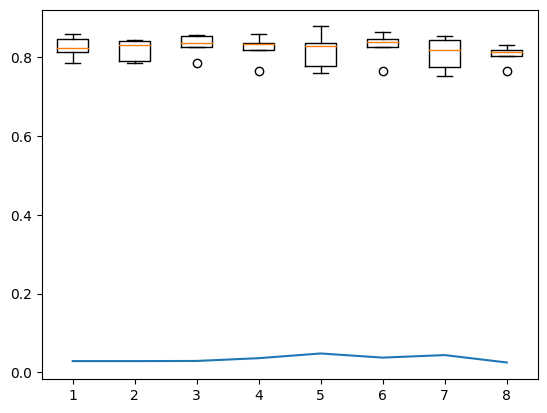

In [ ]:
plt.boxplot(df[df.columns]);
plt.plot([i for i in range(1, len(df.columns) + 1)], df.describe().transpose()["std"]);

We will show its mean and standar deviation too.

In [ ]:
df.describe().transpose()[["mean", "std"]]

,mean,std
"1(150, 150)HoleMakerBounded",0.826007,0.028326
"1(150, 150)HoleMakerAttention",0.818290,0.028316
"1(250, 250)HoleMakerBounded",0.831288,0.028721
"1(250, 250)HoleMakerAttention",0.822359,0.035786
"2(150, 150)HoleMakerBounded",0.816817,0.047726
"2(150, 150)HoleMakerAttention",0.828282,0.037214
"2(250, 250)HoleMakerBounded",0.808998,0.043636
"2(250, 250)HoleMakerAttention",0.806468,0.024847


We save the results in order to plot them together.

In [ ]:
folds = [["COS" + r[0], *r[1]] for r in results.items()]
df = pd.read_csv("SSA_testing.csv")
_df = pd.DataFrame(folds, columns = df.columns)
df = pd.concat([df, _df])
df.to_csv("SSA_testing.csv", index = False)

Finally, we can plot an example of inference.

In [ ]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
               get_items = get_image_files,
               get_y = get_y_fn,
               splitter = FuncSplitter(lambda x: Path(x).parent.name == "train"),
               item_tfms = [Resize((480,640)), TargetMaskConvertTransform()],
               batch_tfms = Normalize.from_stats(*imagenet_stats)
              )

dls = db.dataloaders(path_images, bs = 4)
learner = unet_learner(dls, **learner_hparams).to_fp16()
learner = learner.load("CutOutSemantic")

mask = learner.predict(dls.train_ds[6][0])
print(np.unique(mask[0]))
mask = PILImage.create(decodes(mask[0]))

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0 1 2 3 4]


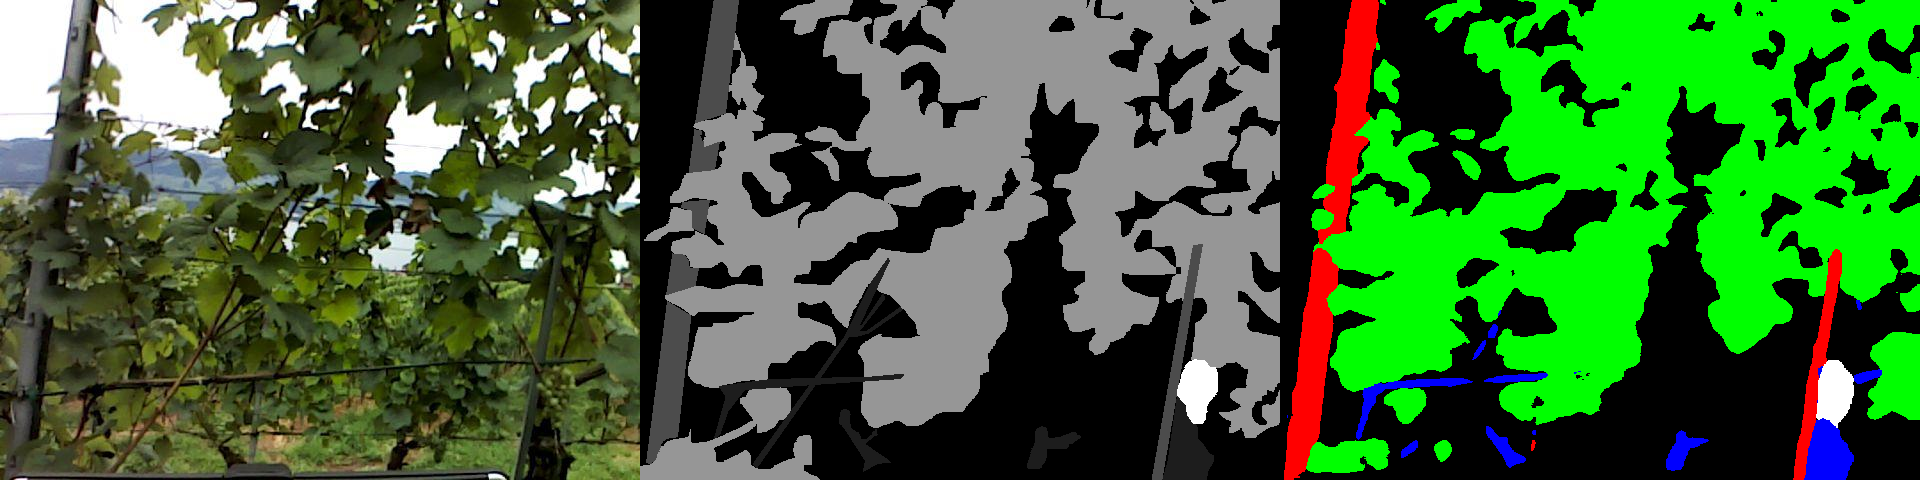

In [ ]:
image_grid([dls.train_ds[6][0], dls.train_ds[6][1], mask], rows = 1, cols = 3)